In [80]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

## Carga de datos en bruto

In [24]:
df = pd.read_csv("data/data.csv")

In [8]:
df.head()

,numero_aviso,marca,codigo_irs,nombre,accion,accion_modelo,marca.1,anio,linea,grupo,subgrupo,tipo_carroceria
0,44023,HYUNDAI,03060003nndn,computadora,cambiar,cambiar,HYUNDAI,2012,accent,3,6,sedan
1,44023,HYUNDAI,03030005nndn,cable ground de bateria,cambiar,cambiar,HYUNDAI,2012,accent,3,3,sedan
2,17203,NISSAN,02090225nidn,pollera delantero izquierdo,cambiar,cambiar,NISSAN,2015,FRONTIER,2,9,pickup
3,37133,KIA,03040016nidn,lampara delantero izquierdo,cambiar,reparar,KIA,2018,rio,3,4,sedan
4,17434,HONDA,02090021nddn,bisagra derecho tapa motor,cambiar,cambiar,HONDA,2016,CRV,2,9,camioneta


In [7]:
print(f"Cantidad de variables {len(df.columns)}, cantidad de observaciones {len(df)}")

Cantidad de variables 12, cantidad de observaciones 103032


In [9]:
profile = ProfileReport(df, minimal=False)
profile.to_file("eda_files/output_initial.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Procesado de datos según recomendaciones EDA inicial

En esta etapa se analizaran las variables en función de las recomendaciones del EDA, esto con el fin de tener los datos refinados para modelaros posteriormente, **el análisis preliminar se encuentra** como un pagina web en la la ubicación: **eda_files/output_initial.htm**

### Filas repetidas (Descartado)

**Nota:** Se descarta esta acción dado que al no tener un identificador de fecha podría ser un vehículo igual con un cambio de partes similar, pero se deja el código en caso de enriquecer la información en un futuro

*Para este caso se tiene 122 filas duplicadas que corresponden al 0.1% del total de los datos aunque no es significativo el borrarlas no lleva un mayo esfuerzo y se proceden a eliminar*

In [17]:
len(df)

103032

In [18]:
len(df)

103032

### Variable numero_aviso

**Numero de aviso:** es un idenficador único que agrupa un siniestro, bajo este ID se puede agrupar las distintas piezas de un siniestro.

**Nota:** Esta variable se esta tomando como tipo numero cuando en realidad es una categoría por esta razón se procede a transformar para poder utilizar de manera mas eficiente en las agrupaciones y en los modelos si se ve su utilidad tratarla como tal

In [25]:
df["numero_aviso"].describe()

count    103032.000000
mean      44333.365479
std       16371.133507
min        8437.000000
25%       29917.000000
50%       47329.000000
75%       58702.000000
max       67229.000000
Name: numero_aviso, dtype: float64

In [26]:
df["numero_aviso"] = df["numero_aviso"].astype(str)

In [27]:
df["numero_aviso"].describe()

count     103032
unique      8708
top        50067
freq         111
Name: numero_aviso, dtype: object

Se puede observar que se están analizando 8708 eventos

### Variable Código irs

**Código irs:** Es un identificador único de cada pieza. Puede que una pieza tenga diferentes nombres (bómper delantero o defensa delantero, bómper del., etc.), pero el código irs será único.

In [57]:
df_irs = df.groupby(["codigo_irs", "nombre"], as_index=False).count()

In [58]:
df_irs = df_irs[["codigo_irs", "numero_aviso", "nombre"]]
df_irs = df_irs.rename(columns={"numero_aviso": "count"})
df_irs = df_irs.sort_values("count", ascending=False)
df_irs = df_irs[0:12].reset_index(drop=True)

In [60]:
df_irs

,codigo_irs,count,nombre
0,02090112nndn,3134,defensa delantero
1,02090113nntn,2194,defensa trasero
2,02090066nddn,2145,guardafango derecho
3,02090200nndn,2111,tapa motor
4,02090067nidn,2077,guardafango izquierdo
5,02090129nndn,1449,parrilla
6,02090143nddn,1416,puerta delantero derecho
7,03040015nddn,1399,lampara delantero derecho
8,03040016nidn,1369,lampara delantero izquierdo
9,02090144nidn,1347,puerta delantero izquierdo


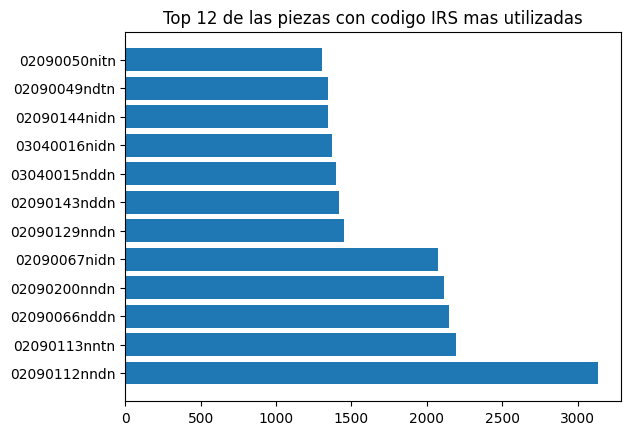

In [55]:
plt.Figure(figsize=(8, 6))
plt.barh(df_irs["codigo_irs"], df_irs["count"])
plt.title("Top 12 de las piezas con codigo IRS mas utilizadas")
plt.show()

Esta variable no tiene problemas salvo una alta cardinalidad es decir muchas categorías, para este caso 1665 valores distintos, pero el top 12 de códigos mas presentes en la base de datos da una idea mas clara de la información

### Variable nombre

**nombre:** nombre de la pieza.

Esta variable no tiene mayor complicación salvo sus valores únicos ya que son 1741 vs 1665 del código irs es decir que pueden haber código irs repetidos con distinto nombre cosa que ya se mencionaba en el diccionario de variables

### Variable acción

**Acción:** Es la acción que finalmente se llevó a cabo sobre la pieza (target).

Esta variable siendo el objetivo del análisis no tiene valores NA y fácil determinar su frecuencia 

In [66]:
df["accion"].value_counts()

cambiar    75598
reparar    27434
Name: accion, dtype: int64

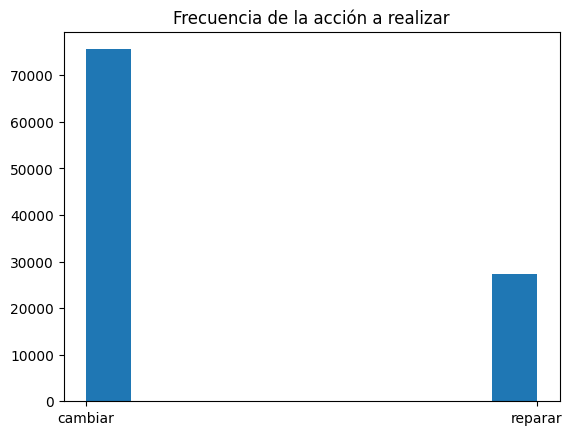

In [61]:
plt.Figure(figsize=(8, 6))
plt.hist(df["accion"])
plt.title("Frecuencia de la acción a realizar")
plt.show()

Se puede observar des balanceo en los datos caso que se debe tener en cuenta a la hora de plantear un modelo

### Acción módelo

**acción_modelo:** es la acción sugerida por el modelo actualmente desplegado
en producción.

Variable interesante para poder comparar

In [65]:
df["accion_modelo"].value_counts()

cambiar    67025
reparar    36007
Name: accion_modelo, dtype: int64

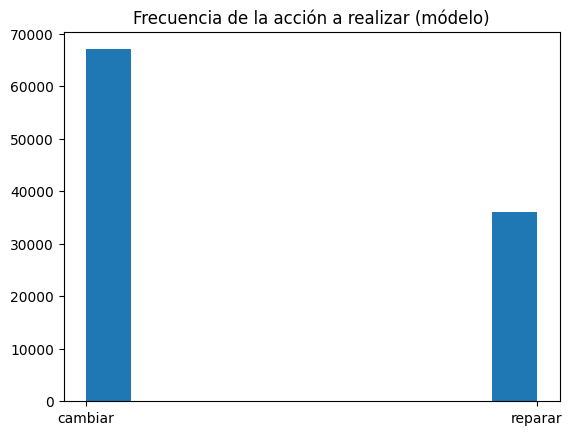

In [62]:
plt.Figure(figsize=(8, 6))
plt.hist(df["accion_modelo"])
plt.title("Frecuencia de la acción a realizar (módelo)")
plt.show()

In [76]:
df_accion = pd.DataFrame(df["accion"].value_counts())
df_accion

,accion
cambiar,75598
reparar,27434


In [77]:
df_accion_modelo = pd.DataFrame(df["accion_modelo"].value_counts())
df_accion_modelo

,accion_modelo
cambiar,67025
reparar,36007


In [81]:
df_model_init = pd.concat([df_accion, df_accion_modelo], axis=1)
df_model_init

,accion,accion_modelo
cambiar,75598,67025
reparar,27434,36007


In [99]:
cambiar_dif =  (df_model_init["accion"][0] / df_model_init["accion_modelo"][0] - 1)
cambiar_dif 

0.12790749720253647

In [102]:
reparar_dif =  (1 - df_model_init["accion"][1] / df_model_init["accion_modelo"][1])
reparar_dif 

0.2380925931068959

Se puede observar como el modelo utilizado es menos efectivo en el caso de reparar piezas puede ser por el des balanceo de los datos, esta información es útil para el planteamiento del modelo